# Importing the relevant libraries

In [1]:
import pandas as pd

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

# Data Preprocessing

### Importing the Database

In [7]:
# Import the data from the CSV file
raw_data = pd.read_csv('ml_datasource.csv')

# Display the first 5 rows of the dataframe for preview
raw_data.head()

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,2,15.81,0
1,SG,260,1.7,1,1,0,16.00,0
2,TR,260,22.4,1,1,0,0.93,0
3,KE,259,18.8,1,1,1,14.63,0
4,IN,259,118.0,2,2,1,16.48,0


In [8]:
data = raw_data.copy()

### Removing Outliers

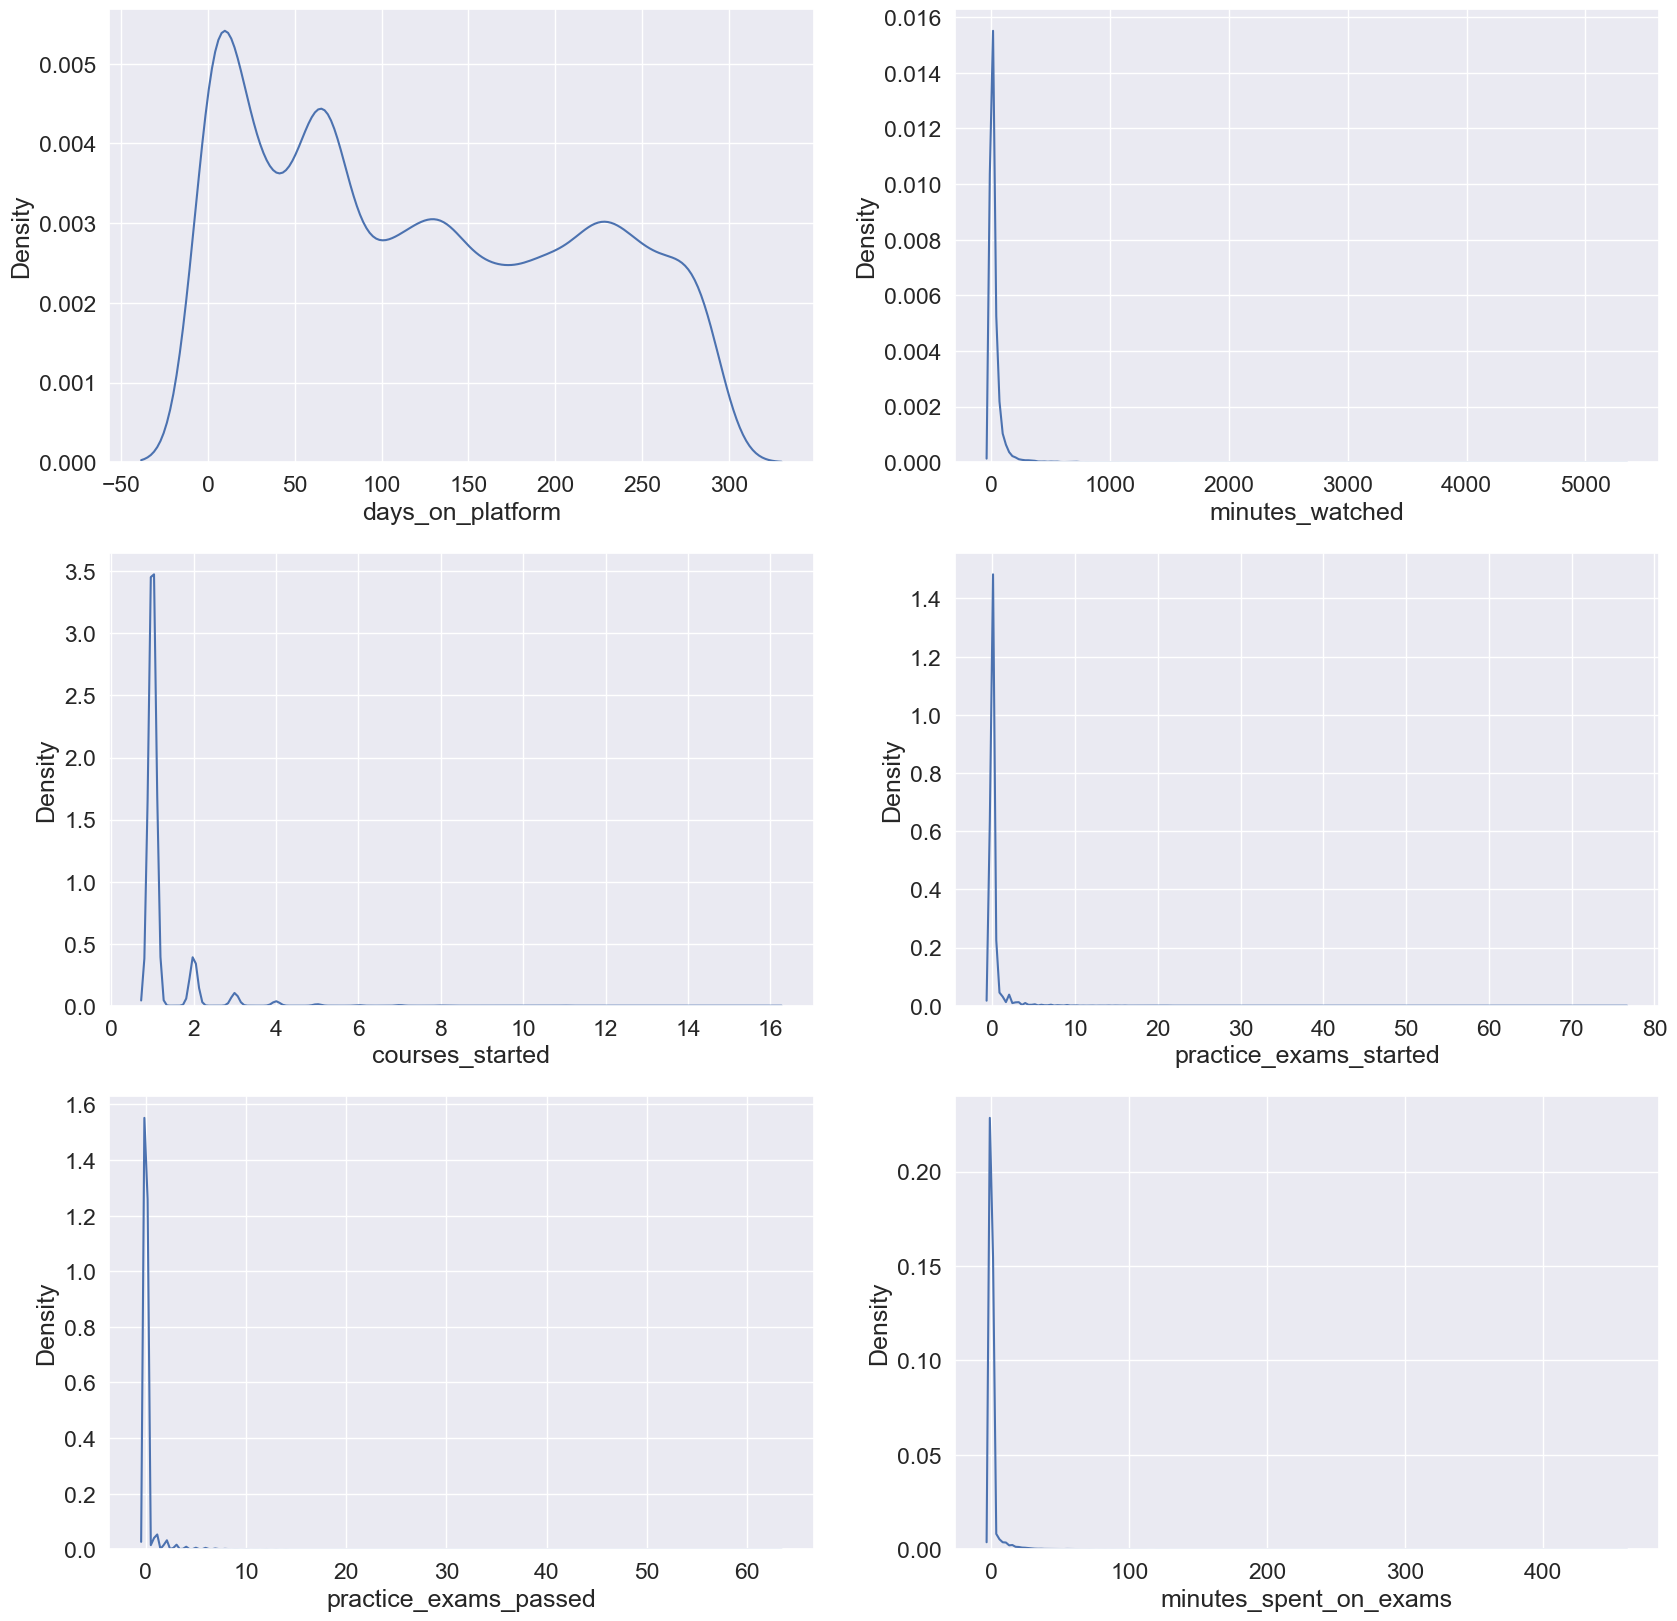

In [9]:
# Reset any modifications to the plotting context (sns) made via seaborn
sns.reset_orig()

# Set the font scale for seaborn plots
sns.set(font_scale=1.5)

# Initialize a grid of plots with specified dimensions
fig, axes = plt.subplots(3, 2, figsize=(20,20))

# Plotting distribution plots for each of the columns in the dataset
sns.kdeplot(data=data['days_on_platform'], ax=axes[0,0])
sns.kdeplot(data=data['minutes_watched'], ax=axes[0,1])
sns.kdeplot(data=data['courses_started'], ax=axes[1,0])
sns.kdeplot(data=data['practice_exams_started'], ax=axes[1,1])
sns.kdeplot(data=data['practice_exams_passed'], ax=axes[2,0])
sns.kdeplot(data=data['minutes_spent_on_exams'], ax=axes[2,1]);

plt.show()

In [10]:
# Removing outliers based on 'minutes_watched', 'courses_started',
# and 'practice_exams_started', and 'minutes_spent_on_exams' fields
data_no_outliers = data[(data['minutes_watched'] <= 1000)
                            & (data['courses_started']<=10)
                            & (data['practice_exams_started']<=10)
                            & (data['minutes_spent_on_exams']<=40)]

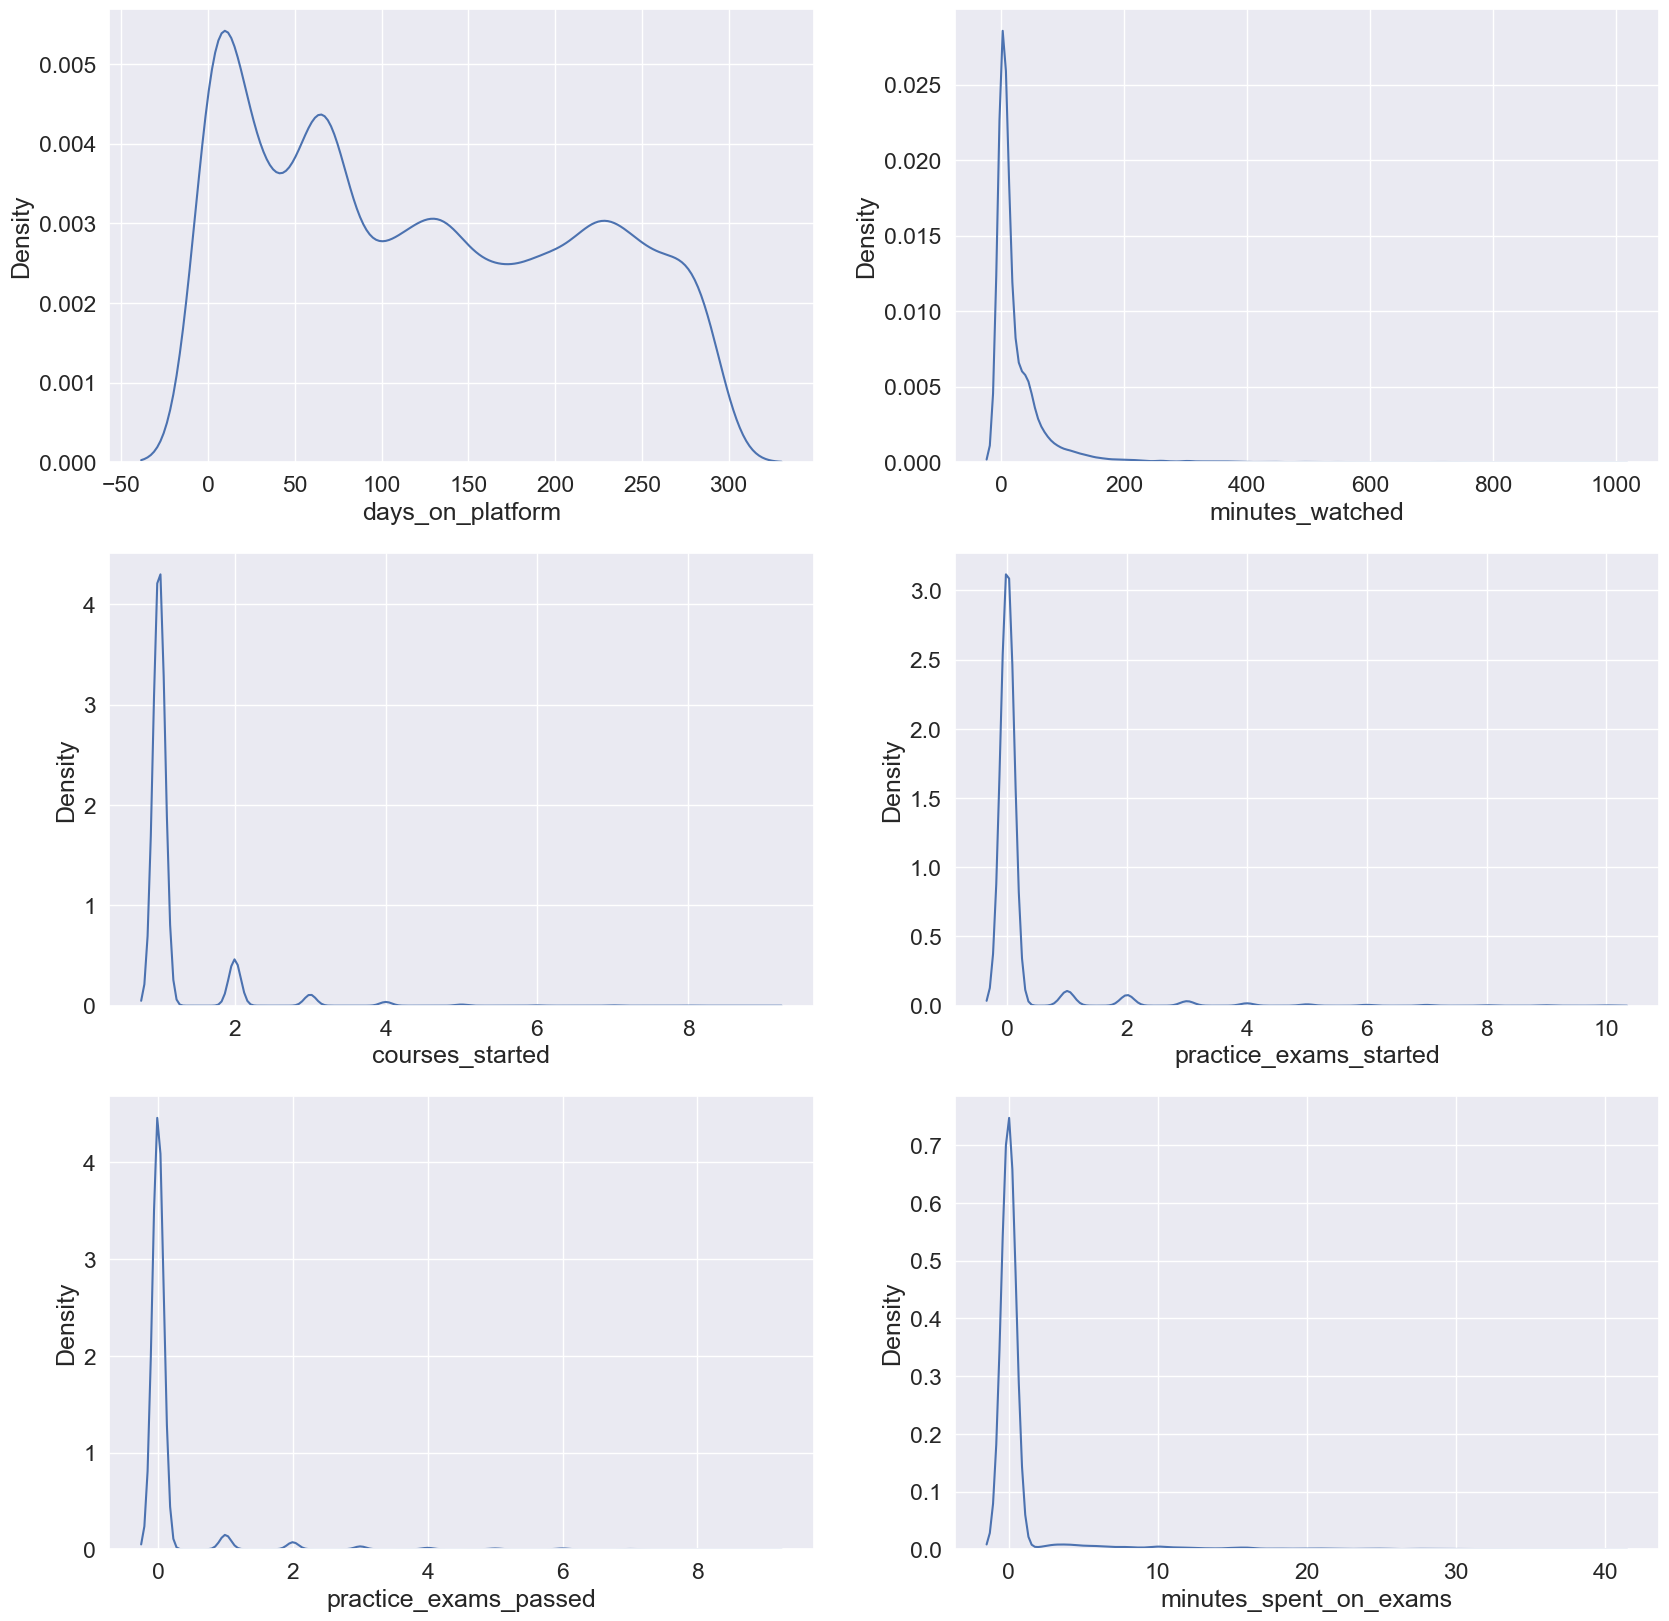

In [11]:
# Reset any modifications to the plotting context (sns) made via seaborn
sns.reset_orig()

# Set the font scale for seaborn plots
sns.set(font_scale=1.5)

# Initialize a grid of plots with specified dimensions
fig, axes = plt.subplots(3, 2, figsize=(20,20))

# Plotting distribution plots for each of the columns in the dataset
sns.kdeplot(data=data_no_outliers['days_on_platform'], ax=axes[0,0])
sns.kdeplot(data=data_no_outliers['minutes_watched'], ax=axes[0,1])
sns.kdeplot(data=data_no_outliers['courses_started'], ax=axes[1,0])
sns.kdeplot(data=data_no_outliers['practice_exams_started'], ax=axes[1,1])
sns.kdeplot(data=data_no_outliers['practice_exams_passed'], ax=axes[2,0])
sns.kdeplot(data=data_no_outliers['minutes_spent_on_exams'], ax=axes[2,1]);

plt.show()

### Checking for Multicollinearity

In [12]:
# Printing the column names of the dataset (for reference)
data_no_outliers.columns.to_numpy()

array(['student_country', 'days_on_platform', 'minutes_watched',
       'courses_started', 'practice_exams_started',
       'practice_exams_passed', 'minutes_spent_on_exams', 'purchased'],
      dtype=object)

In [13]:
# Selecting the numerical columns for Variance Inflation Factor (VIF) calculation
variables = data_no_outliers[['days_on_platform',
                              'minutes_watched',
                              'courses_started', 
                              'practice_exams_started', 
                              'practice_exams_passed', 
                              'minutes_spent_on_exams']]

# Creating a DataFrame to store the VIF value for each feature
vif = pd.DataFrame()

# Computing the VIF for each selected feature using list comprehension
# Storing the values in a column called 'VIF'
vif['VIF'] = [variance_inflation_factor(variables.to_numpy(), i) for i in range(variables.shape[1])]

# Storing the names of the features in a column called 'features'
vif['features'] = variables.columns

# Displaying the DataFrame
vif

,VIF,features
0,2.301237,days_on_platform
1,1.788777,minutes_watched
2,3.178713,courses_started
3,10.201823,practice_exams_started
4,7.812546,practice_exams_passed
5,3.345478,minutes_spent_on_exams


In [14]:
# Dropping 'practice_exams' to prevent multicollinearity 
data_no_mult = data_no_outliers.drop('practice_exams_started', axis = 1)

# Displaying the first five rows of the new data
data_no_mult.head()

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,15.81,0
1,SG,260,1.7,1,0,16.00,0
2,TR,260,22.4,1,0,0.93,0
3,KE,259,18.8,1,1,14.63,0
4,IN,259,118.0,2,1,16.48,0


In [15]:
# Selecting specific columns for new Variance Inflation Factor (VIF) calculation
variables = data_no_outliers[['days_on_platform',
                              'minutes_watched',
                              'courses_started', 
                              'practice_exams_passed', 
                              'minutes_spent_on_exams']]

# Computing the new VIF values for each selected feature
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.to_numpy(), i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif

,VIF,features
0,2.299940,days_on_platform
1,1.788276,minutes_watched
2,3.174319,courses_started
3,2.562412,practice_exams_passed
4,2.602966,minutes_spent_on_exams


### Dealing with NaN Values

In [16]:
# Checking the number of null values in each column
data_no_mult.isnull().sum()

student_country           8
days_on_platform          0
minutes_watched           0
courses_started           0
practice_exams_passed     0
minutes_spent_on_exams    0
purchased                 0
dtype: int64

In [17]:
# Select rows from the 'data_no_mult' DataFrame where the 
# 'student_country' column has missing values (NaN).
data_no_mult.loc[ data_no_mult['student_country'].isna()]

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,purchased
311,NaN,88,58.1,1,2,11.20,1
337,NaN,86,43.0,1,2,12.96,0
556,NaN,121,241.9,2,3,21.29,0
806,NaN,64,86.4,1,2,4.98,0
1097,NaN,72,67.5,1,1,6.27,0
12363,NaN,84,6.2,1,0,0.00,0
12633,NaN,78,3.0,1,0,0.00,0
16946,NaN,11,8.2,1,0,0.00,0


In [18]:
# Replacing NaN values with the string 'NAM'
data_no_nulls = data_no_mult.fillna('NAM', axis = 1)

In [19]:
# Displaying records where 'student_country' is 'NAM'
data_no_nulls.loc[ data_no_nulls['student_country'] == 'NAM', 'student_country']

311      NAM
337      NAM
556      NAM
806      NAM
1097     NAM
12363    NAM
12633    NAM
16946    NAM
Name: student_country, dtype: object

In [20]:
# Re-checking the number of null values in each column after replacement
data_no_nulls.isnull().sum()

student_country           0
days_on_platform          0
minutes_watched           0
courses_started           0
practice_exams_passed     0
minutes_spent_on_exams    0
purchased                 0
dtype: int64

### Splitting the Data

In [21]:
# Defining inputs (feature variables) and target (outcome variable)
inputs = data_no_nulls.drop(['purchased'],axis=1)
target = data_no_nulls['purchased']

In [22]:
# Splitting the data into train and test sets, ensuring balanced classes with stratification
x_train, x_test, y_train, y_test = train_test_split(inputs, 
                                                    target, 
                                                    test_size=0.2, 
                                                    random_state=365,
                                                    stratify = target)

In [23]:
# Display the first 5 rows of the DataFrame for preview
x_train.head()

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams
5718,IN,218,1.6,2,0,0.0
3119,IN,263,75.5,1,0,0.0
5440,LK,222,44.4,1,0,0.0
11828,TR,97,2.6,1,0,0.0
8454,KR,162,1.0,1,0,0.0


### Encoding the Data

In [24]:
# Initializing an ordinal encoder for categorical variables
enc = OrdinalEncoder(handle_unknown = 'use_encoded_value', 
                     unknown_value = 170);

In [25]:
# Encoding the 'student_country' column in the training and testing datasets
# and storing the encoded variable in a new column called 'student_country_enc'
x_train['student_country_enc'] = enc.fit_transform(x_train['student_country'].to_numpy().reshape(-1, 1));
x_test['student_country_enc'] = enc.transform(x_test['student_country'].to_numpy().reshape(-1, 1));

# Dropping the original 'student_country' column after encoding
x_train = x_train.drop('student_country', axis = 1)
x_test = x_test.drop('student_country', axis = 1)

# Displaying the first five rows of the encoded training dataset
x_train.head()

,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,student_country_enc
5718,218,1.6,2,0,0.0,69.0
3119,263,75.5,1,0,0.0,69.0
5440,222,44.4,1,0,0.0,84.0
11828,97,2.6,1,0,0.0,148.0
8454,162,1.0,1,0,0.0,80.0


In [26]:
# We use the np.asarray() method to ensure data type consistency and compatibility.
# y_train values are converted to integers and x_train values are converted to floating-point numbers.

x_train_array = np.asarray(x_train, dtype = 'float')
y_train_array = np.asarray(y_train, dtype = 'int')

x_test_array = np.asarray(x_test, dtype = 'float')
y_test_array = np.asarray(y_test, dtype = 'int')

# Creating a Logistic Regression Model

In [27]:
# Creating a logistic regression model using the sm.Logit function
log_reg = sm.Logit(y_train_array, x_train_array)

# Fitting the model to the training data
log_reg_results = log_reg.fit()

# Displaying a summary of the model results
log_reg_results.summary()

Optimization terminated successfully.
         Current function value: 0.153146
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                14100
Model:                          Logit   Df Residuals:                    14094
Method:                           MLE   Df Model:                            5
Date:                Sat, 09 Nov 2024   Pseudo R-squ.:                  0.5019
Time:                        17:26:45   Log-Likelihood:                -2159.4
converged:                       True   LL-Null:                       -4334.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0691      0.002    -31.914      0.000      -0.073      -0.065
x2             0.0144      0.001     19.992      0.000       0.013       0.016
x3            -0.2885      0.060     -4.784      0.000      -0.407      -0.170
x4             0.0840      0.076      1.102      0.270      -0.065       0.233
x5            -0.0670      0.015     -4.332      0.000      -0.097      -0.037
x6             0.0026      0.001      3.983      0.000       0.001       0.004
==============================================================================

Possibly complete quasi-separation: A fraction 0.43 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [28]:
# Generating predictions on the test set and rounding the predictions to nearest integer (0 or 1)
y_test_pred_log_reg = [round(log_reg_results.predict(x_test_array)[i], 0) 
                       for i in range(len(y_test_array))]

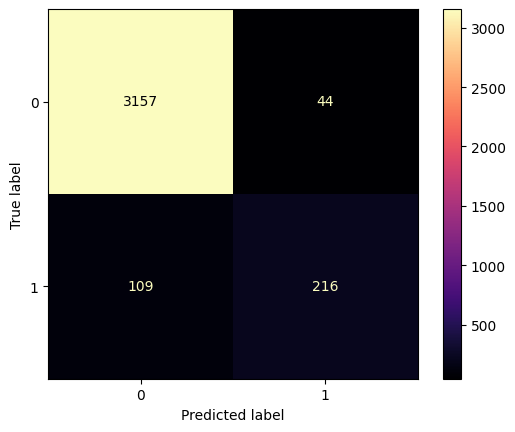

In [29]:
# Resetting any modifications to the plotting context made via seaborn
sns.reset_orig()

# Displaying the confusion matrix from the model's predictions;
# 'magma' colormap is used for better visualization of the matrix;
ConfusionMatrixDisplay.from_predictions(
    y_test_array, y_test_pred_log_reg,
    cmap = 'magma'
);

plt.show()

# Creating a K-Nearest Neighbors Model

In [30]:
# Define the parameter grid for the grid search
parameters_knn = {'n_neighbors':range(1, 51), 
                  'weights':['uniform', 'distance']}

In [31]:
# Initialize a GridSearchCV object with KNeighborsClassifier estimator
# and accuracy as the scoring metric
grid_search_knn = GridSearchCV(estimator = KNeighborsClassifier(), 
                               param_grid = parameters_knn, 
                               scoring = 'accuracy')

In [32]:
# Fit the grid search object on the training data
grid_search_knn.fit(x_train_array, y_train_array)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 51),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [33]:
# Display the best parameters and the corresponding score
grid_search_knn.best_params_, grid_search_knn.best_score_

({'n_neighbors': 10, 'weights': 'distance'}, 0.9598581560283688)

In [34]:
# Store the best estimator (model with optimal parameters) in knn_clf
knn_clf = grid_search_knn.best_estimator_

# Display the model
knn_clf

KNeighborsClassifier(n_neighbors=10, weights='distance')

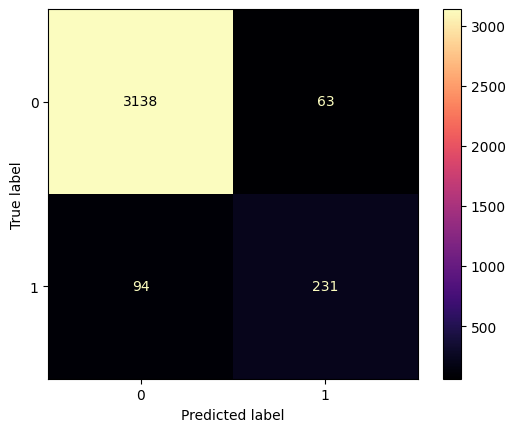

In [35]:
# Predict the target variable for the test dataset using the optimal model
y_test_pred_knn = knn_clf.predict(x_test_array)

# Reset seaborn settings to default
sns.reset_orig()

# Display the confusion matrix using seaborn;
# Set the labels to the classes of the model;
# Choose the magma colormap for better visualization
ConfusionMatrixDisplay.from_predictions(
    y_test_array, y_test_pred_knn,
    labels = knn_clf.classes_,
    cmap = 'magma' 
);

plt.show()

In [36]:
# Print the classification report, providing an overview of how well the classifier has performed
print(classification_report(y_test_array, 
                            y_test_pred_knn, 
                            target_names = ['0', '1']))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3201
           1       0.79      0.71      0.75       325

    accuracy                           0.96      3526
   macro avg       0.88      0.85      0.86      3526
weighted avg       0.95      0.96      0.95      3526



# Creating a Support Vector Machines Model

In [ ]:
# Create an instance of the MinMaxScaler. This will normalize the features to a range between -1 and 1
scaling = MinMaxScaler(feature_range=(-1,1))

# Fit the scaler to the training data and transform it
x_train_array_svc = scaling.fit_transform(x_train_array)

# Use the same scaler to transform the test data
x_test_array_svc = scaling.transform(x_test_array)

In [ ]:
# Set up a dictionary of parameters for grid search
parameters_svc = {'kernel':['linear', 'poly', 'rbf'], 
                  'C':range(1, 11),
                  'gamma': ['scale', 'auto']}

In [ ]:
# Initialize a GridSearchCV object with the SVC estimator and accuracy as the scoring metric
grid_search_svc = GridSearchCV(estimator = SVC(), 
                               param_grid = parameters_svc, 
                               scoring = 'accuracy')

In [ ]:
# Note: Fitting process can take some time due to the number of combinations
grid_search_svc.fit(x_train_array_svc, y_train_array)

In [ ]:
# Display the best model obtained from the grid search
grid_search_svc.best_estimator_

In [ ]:
# Store the best estimator (model with optimal parameters) in svc_clf
svc_clf = grid_search_svc.best_estimator_

In [ ]:
# Use the best estimator to predict the target variable for the test dataset
y_test_pred_svc = svc_clf.predict(x_test_array_svc)

# Reset seaborn settings to default
sns.reset_orig()

# Display the confusion matrix using seaborn;
# Use 'magma' colormap for better visualization
ConfusionMatrixDisplay.from_predictions(
    y_test_array, y_test_pred_svc,
    labels = svc_clf.classes_,
    cmap = 'magma'
);

plt.show()

In [ ]:
# Print the classification report to get precision, recall, f1-score, and support for each class
print(classification_report(y_test_array, 
                            y_test_pred_svc, 
                            target_names = ['0', '1']))

# Creating a Decision Trees Model

In [ ]:
# Define the parameters for the GridSearch. 
# Here we're trying different values for the ccp_alpha parameter
parameters_dt = {'ccp_alpha':[0, 
                              0.001, 
                              0.002, 
                              0.003, 
                              0.004, 
                              0.005]}

In [ ]:
# Initialize GridSearchCV with the estimator being a DecisionTreeClassifier with a fixed random state.
# The scoring metric used here is accuracy
grid_search_dt = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 365), 
                              param_grid = parameters_dt, 
                              scoring = 'accuracy')

In [ ]:
# Fit a GridSearchCV object on the training data
grid_search_dt.fit(x_train_array, y_train_array)

In [ ]:
# Display the best estimator after grid search
grid_search_dt.best_estimator_

In [ ]:
# Assign the model with the best parameters to dt_clf
dt_clf = grid_search_dt.best_estimator_

In [ ]:
# Set the figure size for the plot
plt.figure(figsize=(15,10))

# Plot the decision tree. Feature names and class names are added for better interpretability
plot_tree(dt_clf, 
          filled=True, 
          feature_names = ['Days on platform', 
                           'Minutes watched', 
                           'Courses started',
                           'Practice exams passed', 
                           'Time spent on exams', 
                           'Student country encoded'], 
          class_names = ['Will not purchase', 
                         'Will purchase'])

# Display the plot
plt.show()

In [ ]:
# Use the best decision tree model to predict the target variable for the test dataset
y_test_pred_dt = dt_clf.predict(x_test_array)

In [ ]:
# Reset seaborn settings to default
sns.reset_orig()

# Display the confusion matrix using seaborn.
# Use 'magma' colormap for better visualization
ConfusionMatrixDisplay.from_predictions(
    y_test_array, y_test_pred_dt,
    labels = dt_clf.classes_,
    cmap = 'magma'
);

plt.show()

In [ ]:
# Print the classification report to get precision, recall, f1-score, and support for each class
print(classification_report(y_test_array, y_test_pred_dt))

# Creating a Random Forests Model

In [ ]:
# Initialize the RandomForestClassifier with ccp_alpha set to 0.0001
rf_clf = RandomForestClassifier(ccp_alpha = 0.0001, random_state = 365)

In [ ]:
# Train the random forest model on the training data
rf_clf.fit(x_train_array, y_train_array)

In [ ]:
# Use the trained random forest model to predict the target variable for the test dataset
y_test_pred_rf = rf_clf.predict(x_test_array)

In [ ]:
# Reset seaborn settings to default
sns.reset_orig()

# Display the confusion matrix using seaborn
# Use 'magma' colormap for better visualization
ConfusionMatrixDisplay.from_predictions(
    y_test_array, y_test_pred_rf,
    labels = rf_clf.classes_,
    cmap = 'magma' 
);

plt.show()

In [ ]:
# Print the classification report to get precision, recall, f1-score, and support for each class
print(classification_report(y_test_array, y_test_pred_rf))